In [15]:
from dataclasses import dataclass
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, ndimage
from skimage import transform
from sklearn import datasets
from tqdm import tqdm

In [16]:
mnist = datasets.fetch_openml('mnist_784', as_frame=False, cache=True)

/Users/evan/Programming/miniforge3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [17]:
mnist.data.shape

(70000, 784)

In [18]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X = X[:10000]
y = y[:10000]
X.shape

(10000, 784)

In [19]:
X /= 255.0

In [20]:
def plot_example(X, y, idx=0):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[idx:idx+5].reshape(5, 28, 28), y[idx:idx+5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

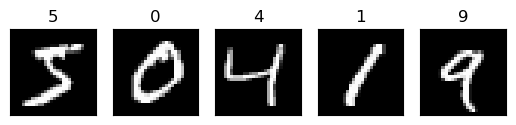

In [21]:
plot_example(X, y)

In [22]:
def qrsvd(X, *, save=False, load=False, file_suffix=None, return_all=False):
    """
    Parameters
    ----------
    X : array-like
        The matrix to decompose.
    save : bool, default=True
        Whether to save the Q, R, U, s, and Vh matrices to disk.
    load : bool, default=True
        Whether to load the Q, R, U, s, and Vh matrices from disk if they exist.
    file_suffix : str, default=""
        The suffix to append to the file names if saving or loading. An underscore
        will be prepended to the suffix if it is given.
    return_all : bool, default=False
        Whether to return all of the matrices or just the singular values.
    """
    file_suffix = "" if file_suffix is None else f"_{file_suffix}"
    # These are separate try/except blocks so that if the QR decomposition succeeds
    # but the SVD fails, we don't have to recompute the QR decomposition.
    try:
        if not load:
            raise OSError
        Q = np.load(f"Q{file_suffix}.npy")
        R = np.load(f"R{file_suffix}.npy")
    except OSError:
        Q, R = linalg.qr(X)
        if save:
            np.save(f"Q{file_suffix}.npy", Q)
            np.save(f"R{file_suffix}.npy", R)

    try:
        if not load:
            raise OSError
        U = np.load(f"U{file_suffix}.npy")
        s = np.load(f"s{file_suffix}.npy")
        Vh = np.load(f"Vh{file_suffix}.npy")
    except OSError:
        U, s, Vh = linalg.svd(R)
        if save:
            np.save(f"U{file_suffix}.npy", U)
            np.save(f"s{file_suffix}.npy", s)
            np.save(f"Vh{file_suffix}.npy", Vh)

    return (Q, U, s, Vh) if return_all else s

In [12]:
s = qrsvd(X)

In [23]:
figsize = (13.33, 7.5)
dpi = 96
tick_labelsize = 16
linewidths = 4
label_fontsize = 20
title_fontsize = 24

In [24]:
def plot_singular_values(*s_list, labels=None, title:str=None, save=False):
    """Plot the singular values of the given matrices."""
    plt.figure(figsize=figsize, dpi=dpi)
    plt.tick_params(labelsize=tick_labelsize)
    plt.xlabel("Index", fontsize=label_fontsize)
    plt.ylabel("Log of Singular Value", fontsize=label_fontsize)
    if title is not None:
        plt.title(title, fontsize=title_fontsize)
    for s in s_list:
        plt.scatter(np.arange(len(s)), np.log(s), linewidths=linewidths)
    if labels is not None:
        plt.legend(labels, fontsize=label_fontsize)
    plt.tight_layout()
    if save:
        plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

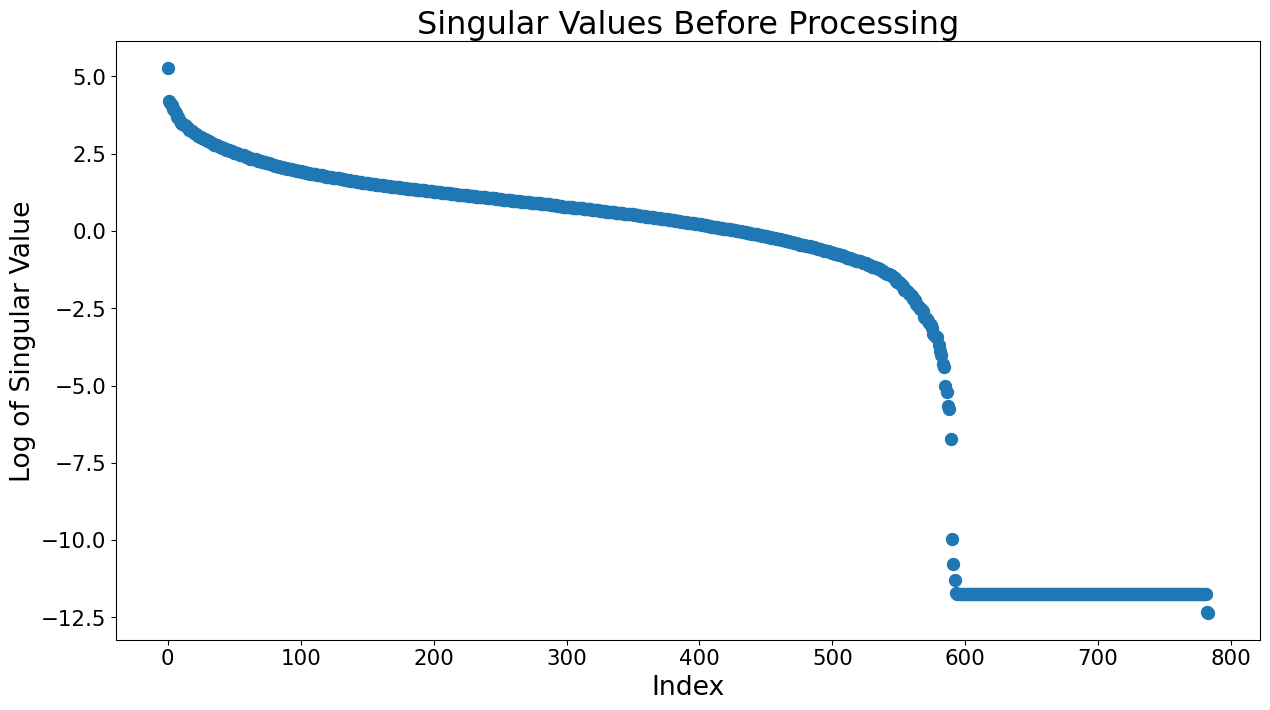

In [80]:
plot_singular_values(s, title="Singular Values Before Processing")

## Recentering by Bounding Box

In [9]:
# modified code, original source: https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
def find_bbox(img):
    img = np.where(img>0.3, img, 0)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax+1, cmin, cmax+1

In [10]:
def recenter_imgs(imgs):
    imgs_recentered = np.zeros_like(imgs)

    for i, img in tqdm(enumerate(imgs)):
        img = img.reshape(28,28)
        rmin, rmax, cmin, cmax = find_bbox(img)
        # bbox_center = ((rmin + rmax)//2,  (cmin + cmax)//2)
        
        bbox_img = img[rmin:rmax, cmin:cmax]

        padr1 = padr2 = (28-(rmax-rmin))//2
        padc1 = padc2 = (28-(cmax-cmin))//2

        if (rmax+rmin)%2 == 1:
            padr2 += 1
        if (cmax+cmin)%2 == 1:
            padc2 += 1

        recentered_img = np.pad(bbox_img, ((padr1, padr2), (padc1, padc2)))
        imgs_recentered[i] = recentered_img.flatten()

    return imgs_recentered

1000it [00:00, 24596.56it/s]

7 27 8 20
(17, 14)


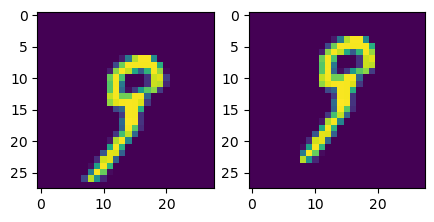

In [11]:
X_recentered = recenter_imgs(X)

fig, axes = plt.subplots(1,2, figsize=(5,2.5))
axes[0].imshow(X[19].reshape(28,28))
axes[1].imshow(X_recentered[19].reshape(28,28))

rmin, rmax, cmin, cmax = find_bbox(X[19].reshape(28,28))
bbox_center = ((rmin + rmax)//2,  (cmin + cmax)//2)
print(rmin, rmax, cmin, cmax)
print(bbox_center)

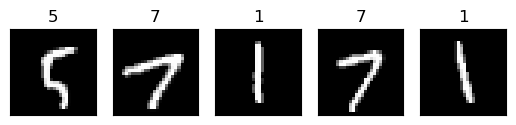

In [12]:
plot_example(X, y, idx=100)

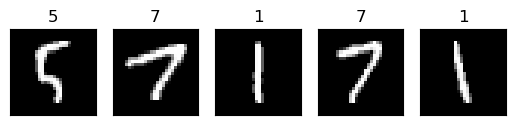

In [13]:
plot_example(X_recentered, y, idx=100)

In [48]:
s_rec = qrsvd(X_recentered)

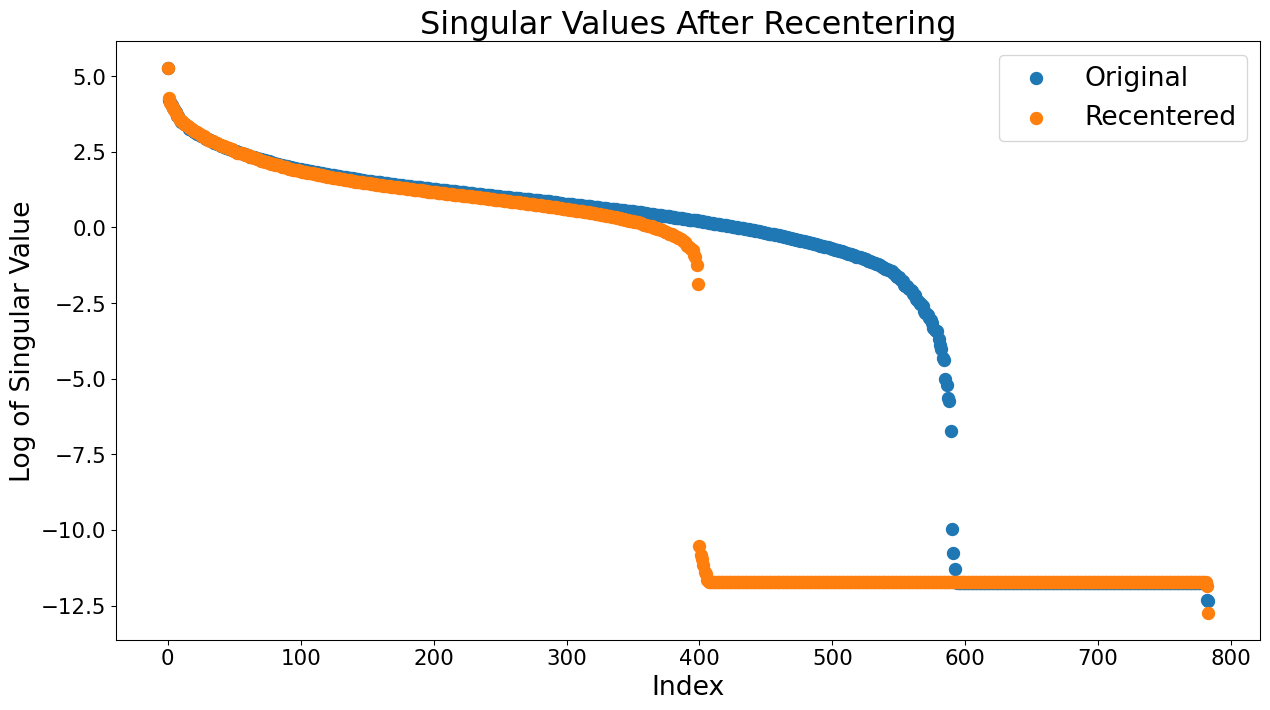

In [81]:
plot_singular_values(
    s, s_rec,
    labels=["Original", "Recentered"],
    title="Singular Values After Recentering",
    save=True,
)

## Split by class

In [ ]:
digits = {}
si_list = []

for i in range(10):
    digits[i] = X[y==i]

In [ ]:
for i in range(10):
    print(digits[i].shape)
    si = qrsvd(digits[i])
    si_list.append(si)

In [ ]:
fig, ax = plt.subplots(10, 1, figsize=(10,30))

for i in range(10):
    ax[i].scatter(np.arange(0,784), np.log(si_list[i]))
    ax[i].set_title(f'Singular Values for Class [i]')

In [ ]:
plot_singular_values(
    *si_list,
    labels=[f"Class {i}" for i in range(10)],
    title="Singular Values for Each Digit"
)

### By class and recentered

In [ ]:
digits_rec = {}
si_rec_list = []

for i in range(10):
    digits_rec[i] = X_recentered[y==i]

In [ ]:
for i in range(10):
    print(digits_rec[i].shape)
    si = qrsvd(digits_rec[i])
    si_rec_list.append(si)

(1001, 784)
(1127, 784)
(991, 784)
(1032, 784)
(980, 784)
(863, 784)
(1014, 784)
(1070, 784)
(944, 784)
(978, 784)


In [ ]:
plot_singular_values(
    *si_rec_list,
    labels=[f"Class {i}" for i in range(10)],
    title="Singular Values for Each Digit After Recentering"
)

In [14]:
def find_cutoff(arr, cutoff=0.001):
    return np.where(arr < cutoff)[0][0]

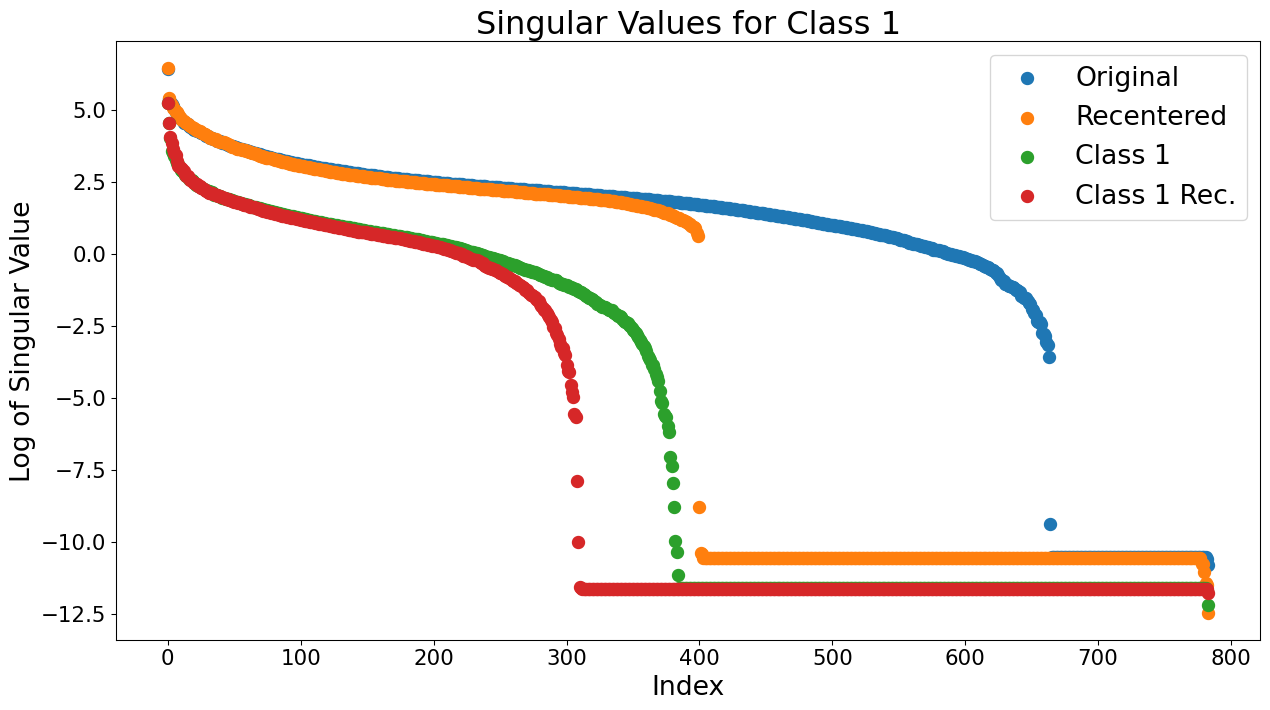

664 400 378 308


In [ ]:
class_num = 1
plot_singular_values(
    s, s_rec, si_list[class_num], si_rec_list[class_num],
    labels=["Original", "Recentered", f"Class {class_num}", f"Class {class_num} Rec."],
    title=f"Singular Values for Class {class_num}",
    save=False,
    # figsize=(12,6)
)

print(find_cutoff(s), find_cutoff(s_rec), find_cutoff(si_list[1]),find_cutoff(si_rec_list[1]))

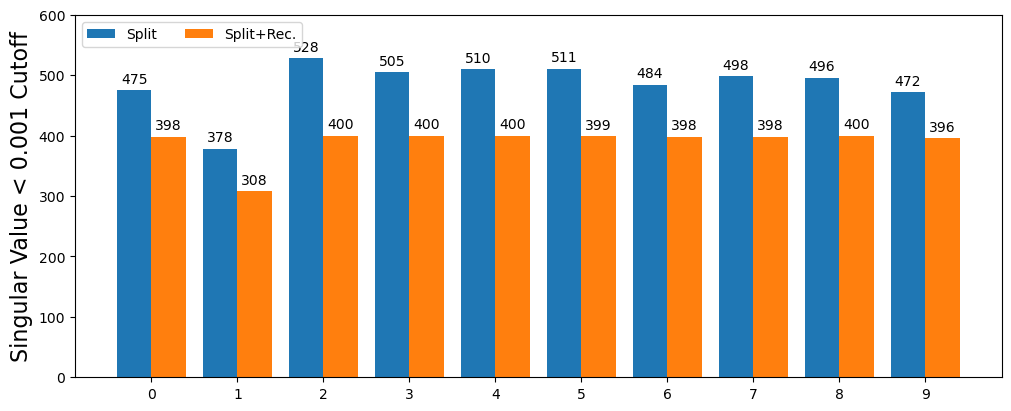

In [ ]:
classes = [f'{i}' for i in range(10)]
cutoffs = {
    # 'Original': [find_cutoff(s) for i in range(10)],
    # 'Rec.': [find_cutoff(s_rec) for i in range(10)],
    'Split': [find_cutoff(si_list[i]) for i in range(10)],
    'Split+Rec.': [find_cutoff(si_rec_list[i]) for i in range(10)],
}

x = np.arange(len(classes))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,4))

for attribute, measurement in cutoffs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Singular Value < 0.001 Cutoff',fontsize=16)
ax.set_xticks(x + width/2, classes)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 600)

plt.show()

## Nonlinear transformation

In [ ]:
X2 = (X>0.5).astype('float32')
s2 = qrsvd(X2)

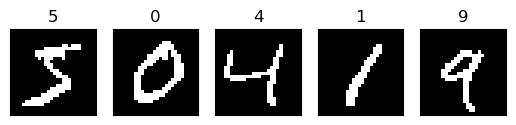

In [40]:
plot_example(X2, y)

In [27]:
X3 = (np.square(X)>0.75).astype('float32')
s3 = qrsvd(X3)

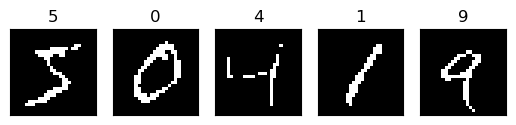

In [39]:
plot_example(X3, y)

In [35]:
X4 = (np.sqrt(X)>0.99).astype('float32')
s4 = qrsvd(X4)

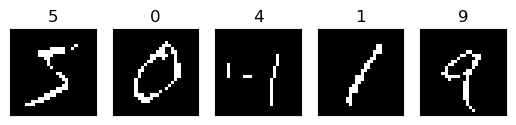

In [38]:
plot_example(X4, y)

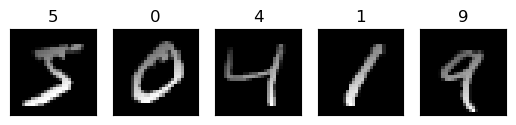

In [37]:
def weight_by_position(X):
    X_weighted = np.zeros_like(X)
    for i, img in enumerate(X):
        img = img.reshape(28,28).copy()
        for r in range(28):
            for c in range(28):
                img[r,c] *= (r/56 + c/56/2)
        X_weighted[i] = img.flatten()
    return X_weighted

X_weighted = weight_by_position(X)
plot_example(X_weighted, y)
X5 = (X_weighted>0.25).astype('float32')
s5 = qrsvd(X5)

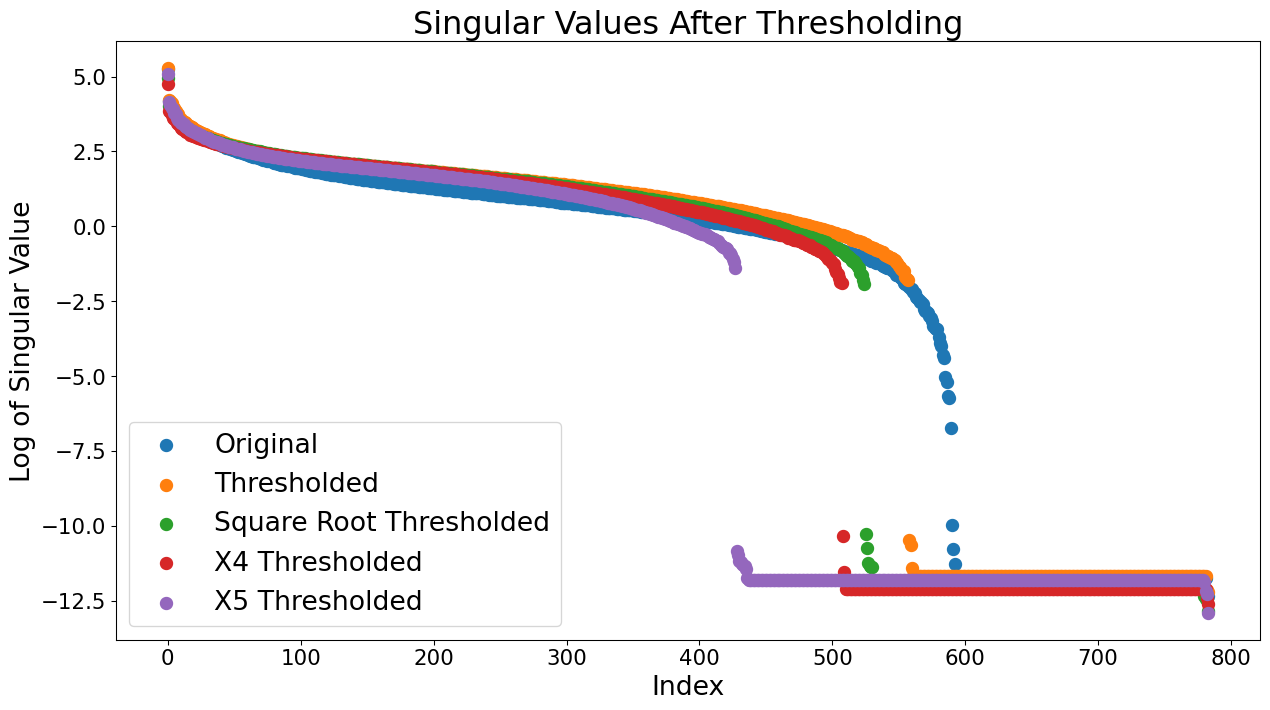

In [90]:
plot_singular_values(
    s, s2, s3, s4, s5,
    labels=["Original", "Thresholded", "Square Root Thresholded", "X4 Thresholded", "X5 Thresholded"],
    title="Singular Values After Thresholding",
    # save=True,
)

## Rotation

### Using linear regression

In [41]:
@dataclass
class Line:
    x1: float
    y1: float
    x2: float
    y2: float

    def __post_init__(self):
        self.is_vertical = self.x1 == self.x2
        self._rise = self.y2 - self.y1
        self._run = self.x2 - self.x1
        if not self.is_vertical:
            self._slope = self._rise / self._run
            self._intercept = self.y1 - self._slope * self.x1
        else:
            self._slope = math.inf
            self._intercept = math.nan

    @classmethod
    def from_angle(cls, angle, point=(0, 0)):
        x1, y1 = point
        if angle == 90 or angle == 270:
            return cls(x1, y1, x1, y1 + 1)
        slope = math.tan(math.radians(angle))
        return cls(x1, y1, x1 + 1, y1 + slope)

    def __call__(self, x):
        """Returns the y value of the line at x."""
        if self.is_vertical:
            return math.nan
        return self._slope * x + self._intercept

    def for_graph(self, x_min, x_max, y_min=None, y_max=None):
        """Returns the x and y values for the line between x_min and x_max."""
        if self.is_vertical:
            return (self.x1, self.x1), (y_min, y_max)
        return (x_min, x_max), (self(x_min), self(x_max))

    def angle(self):
        """Returns the angle of inclination of the line."""
        return math.degrees(math.atan2(self._rise, self._run))

    def angle_to(self, other):
        """Returns the angle from this line to another line."""
        return other.angle() - self.angle()

In [96]:
# https://stackoverflow.com/a/52812908

def feature(x, order):
    """Generate polynomial feature of the form
    [1, x, x^2, ..., x^order] where x is the column of x-coordinates
    and 1 is the column of ones for the intercept.
    """
    x = x.reshape(-1, 1)
    return np.power(x, np.arange(order + 1).reshape(1, -1))


def regress(img: np.ndarray, *, order, alpha=0.01, threshold=0.25, weighted=True):
    mask = img > threshold
    indices = np.argwhere(mask) # Get indices of pixels corresponding to marked region

    X = indices[:, 1].reshape(-1, 1) # Column indices
    X = feature(X, order) # Polynomial features
    Y = indices[:, 0] # Row indices to predict. Note origin is at top left corner

    X_T = X.T
    if weighted:
        W = np.diag(img[mask] / float(img.max())) # weight matrix
        X_T = X_T.dot(W)

    I = np.eye(X.shape[1])
    B = np.linalg.pinv(X_T.dot(X) + alpha * I).dot(X_T).dot(Y)
    return B

def linreg(img: np.ndarray, **kwargs):
    B = regress(img, order=1, **kwargs)
    x = np.asarray([0, img.shape[1] - 1])
    y = feature(x, 1).dot(B)
    return Line(x[0], y[0], x[1], y[1])

def plot_reg(img: np.ndarray, *, order=1, n_samples=2, ylim=(27, 0), ax=None, **kwargs):
    B_unw = regress(img, order=order, weighted=False, **kwargs)
    B_w = regress(img, order=order, weighted=True, **kwargs)
    x = np.linspace(0, img.shape[1] - 1, n_samples)
    y_unw = feature(x, order).dot(B_unw)
    y_w = feature(x, order).dot(B_w)

    ax = plt.gca() if ax is None else ax
    ax.imshow(img, cmap='gray')
    ax.set_ylim(*ylim)
    ax.plot([0, 27], [14, 14], linestyle='--', label='Center')
    ax.plot(x, y_unw, label='Unweighted')
    ax.plot(x, y_w, label='Weighted')
    ax.legend(fontsize="xx-small")

In [42]:
# homegrown
def linreg2(img: np.ndarray, *, threshold=0, weighted=True):
    Y, X = np.nonzero(img > threshold)
    A = np.vstack([X, np.ones(len(X))]).T

    if weighted:
        weights = img[X, Y] / float(img.max())
        W = np.diag(weights)
        m, c = np.linalg.lstsq(A.T.dot(W).dot(A), A.T.dot(W).dot(Y), rcond=None)[0]
    else:
        m, c = np.linalg.lstsq(A, Y, rcond=None)[0]

    return Line(0, c, 27, m * 27 + c)

In [94]:
def test_linreg_rotation(img, *, linreg=linreg, order=1, **kwargs):
    img = img.reshape(28, 28)
    B = linreg(img, **kwargs)
    print(f"Angle from x-axis: {B.angle('deg'):.2f} degrees")

    img_rot = ndimage.rotate(img, angle=-B.angle('deg'), reshape=False, order=order)
    img_rot2 = transform.rotate(img, angle=-B.angle("deg"), order=order, preserve_range=True)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
    plt.ylim(0, 27)
    plot_reg(img, ax=axes[0], **kwargs)
    plot_reg(img_rot, ax=axes[1], **kwargs)
    plot_reg(img_rot2, ax=axes[2], **kwargs)

Angle to x-axis: 26.36 degrees


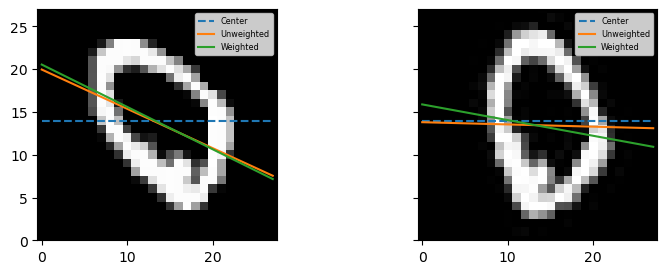

In [ ]:
test_linreg_rotation(X[1], threshold=0, order=4)

Angle to x-axis: 18.33 degrees


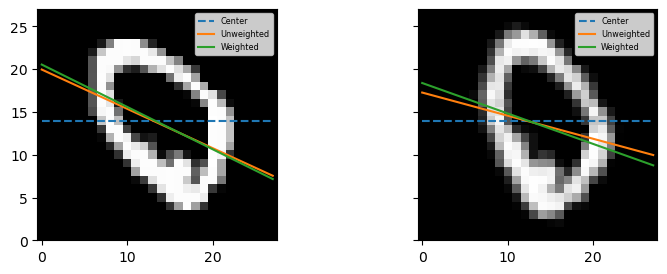

In [ ]:
test_linreg_rotation(X[1], threshold=0, linreg=linreg2)

In [99]:
def test_straighten_linreg(imgs, *, order=None, **kwargs):
    # imgs has shape (n, 784)

    # plot singular values of imgs, imgs rotated by angle, and imgs
    # rotated by angle + 90

    imgs = imgs.reshape(-1, 28, 28)
    angles = np.asarray([
        -linreg(img, **kwargs, weighted=True).angle() for img in imgs
    ])
    imgs_rot = np.asarray([
        transform.rotate(img, angle=angle, order=order) for img, angle in zip(imgs, angles)
    ]).reshape(-1, 784)
    imgs = imgs.reshape(-1, 784)

    s = qrsvd(imgs, save=False, load=False)
    s_rot = qrsvd(imgs_rot, save=False, load=False)
    plot_singular_values(
        s, s_rot,
        labels=["Original", "Rotated", "Weighted Rotated"],
        title="Singular Values After Straightening with Linear Regression",
        # save=True,
    )

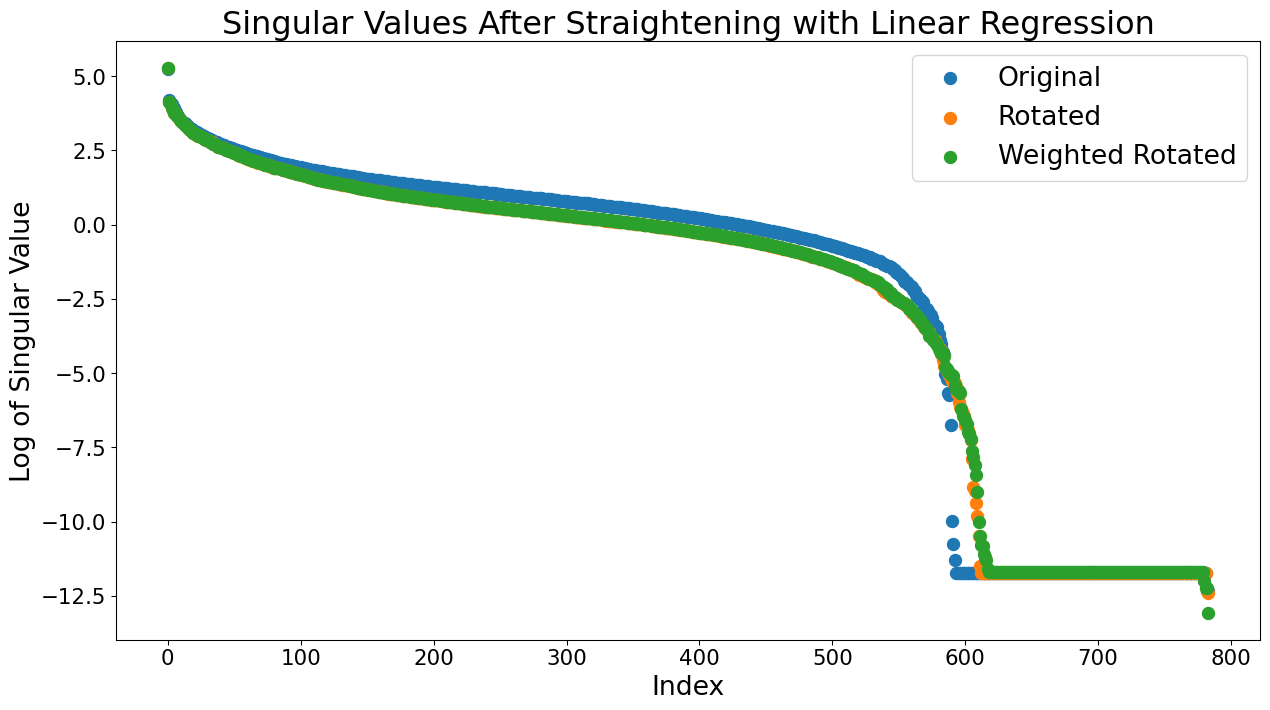

In [100]:
test_straighten_linreg(X[:1000], threshold=0.5, order=1)

### Using Radon transform

##### Messing with Radon transform to try to understand it

In [ ]:
from skimage import draw
a = np.zeros((28, 28))
rr, cc = draw.line(8, 0, 10, 27)
a[rr, cc] = 1
rr, cc = draw.line(0, 10, 27, 7)
# a[rr, cc] = 1

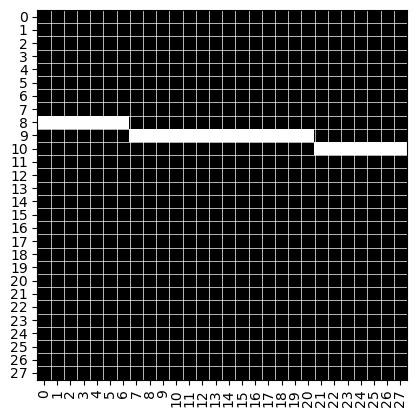

In [ ]:
plt.imshow(a, cmap='gray')
ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 28, 1))
ax.set_yticks(np.arange(0, 28, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, 28, 1))
ax.set_yticklabels(np.arange(0, 28, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, 27, 1), minor=True)
ax.set_yticks(np.arange(-.5, 27, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
plt.xticks(rotation=90)
# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)

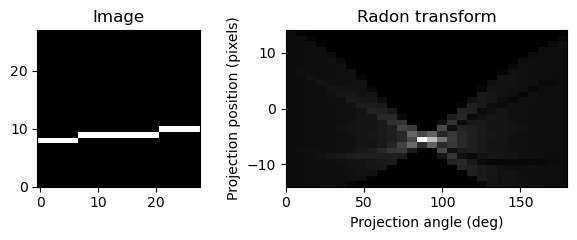

In [ ]:
img = a

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5), width_ratios=[1, 1.5])

ax1.set_title("Image")
# ax1.set_ylim([27, 0])
ax1.set_ylim([0, 27])
ax1.imshow(img, cmap='gray')

theta = np.linspace(0., 180., max(img.shape), endpoint=False)
sinogram = transform.radon(img, theta=theta, circle=True)
# dx, dy = 0.5 * 180.0 / max(img.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap='gray',
        #    extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           extent=(0, 180, -sinogram.shape[0]//2, sinogram.shape[0]//2),
           aspect='auto')

n = 1
for i, (offset_i, angle_i) in enumerate(zip(
    *np.unravel_index(np.argsort(sinogram, axis=None)[-n:], sinogram.shape)
)):
    offset = np.arange(-sinogram.shape[0]//2, sinogram.shape[0]//2)[offset_i]
    angle = theta[angle_i]
    angle_rad = np.deg2rad(angle)
#     # plot the line from the angle
#     x1 = 0
#     x2 = 27
#     y1 = (x1 * np.cos(angle_rad)) / np.sin(angle_rad) - offset - 1
#     y2 = (x2 * np.cos(angle_rad)) / np.sin(angle_rad) - offset - 1
#     ax1.plot([x1, x2], [y1, y2])

fig.tight_layout()
plt.show()

##### Using Radon transform

In [101]:
# In the worst case where I'm not understanding it correctly,
# the point is that the method is the same for every image, so
# it should be fine either way.

def straightening_angle(img: np.ndarray, theta=None):
    if theta is None:
        theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = transform.radon(img, theta=theta)
    _, max_col = np.unravel_index(np.argmax(sinogram), sinogram.shape)
    angle = -theta[max_col]
    return angle

def straighten(img: np.ndarray, resize=False, **kwargs):
    angle = straightening_angle(img, theta=kwargs.pop("theta", None))
    return transform.rotate(img, angle, resize=resize, **kwargs)

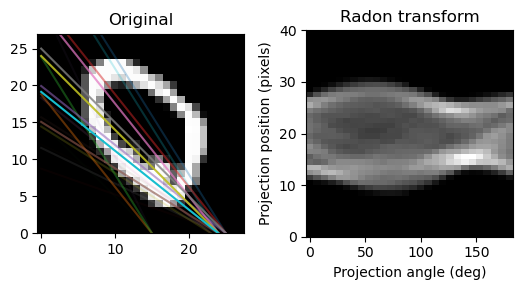

In [ ]:
img = X[1].reshape(28, 28)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.333, 3))

ax1.set_title("Original")
ax1.set_ylim([0, 27])
ax1.imshow(img, cmap='gray')

theta = np.linspace(0., 180., max(img.shape), endpoint=False)
sinogram = transform.radon(img, theta=theta, circle=False)
dx, dy = 0.5 * 180.0 / max(img.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap='gray',
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

n = 20
for i, (offset, angle_i) in enumerate(zip(
    *np.unravel_index(np.argsort(sinogram, axis=None)[-n:], sinogram.shape)
)):
    ax1.plot(*Line.from_angle(theta[angle_i], (offset, 0)).for_graph(0, 27), alpha=(i+1)**2/n**2)

fig.tight_layout()
plt.show()

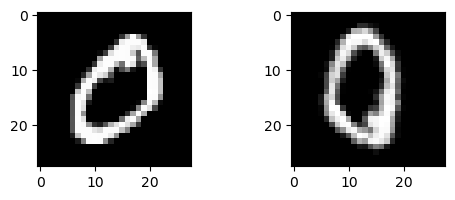

In [ ]:
img = X[1].reshape(28, 28)

fig, axes = plt.subplots(1, 2, figsize=(6, 2))

axes[0].imshow(img, cmap="gray")
axes[1].imshow(straighten(img), cmap="gray")

plt.show()

In [ ]:
def test_straighten(imgs, **kwargs):
    imgs = imgs.reshape(-1, 28, 28)
    imgs_rot = np.asarray([
        straighten(img, **kwargs) for img in imgs
    ]).reshape(-1, 784)
    # imgs_rot_recentered = recenter_imgs(imgs_rot)
    imgs = imgs.reshape(-1, 784)

    s = qrsvd(imgs, save=False, load=False)
    s_rot = qrsvd(imgs_rot, save=False, load=False)
    # s_rot_recentered = qrsvd(imgs_rot_recentered, save=False, load=False)

    plot_singular_values(
        s, s_rot,
        labels=["Original", "Rotated", "Rotated and Recentered"],
        title="Singular Values After Straightening with Radon Transform",
        save=True,
    )

/Users/evan/Programming/miniforge3/lib/python3.9/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


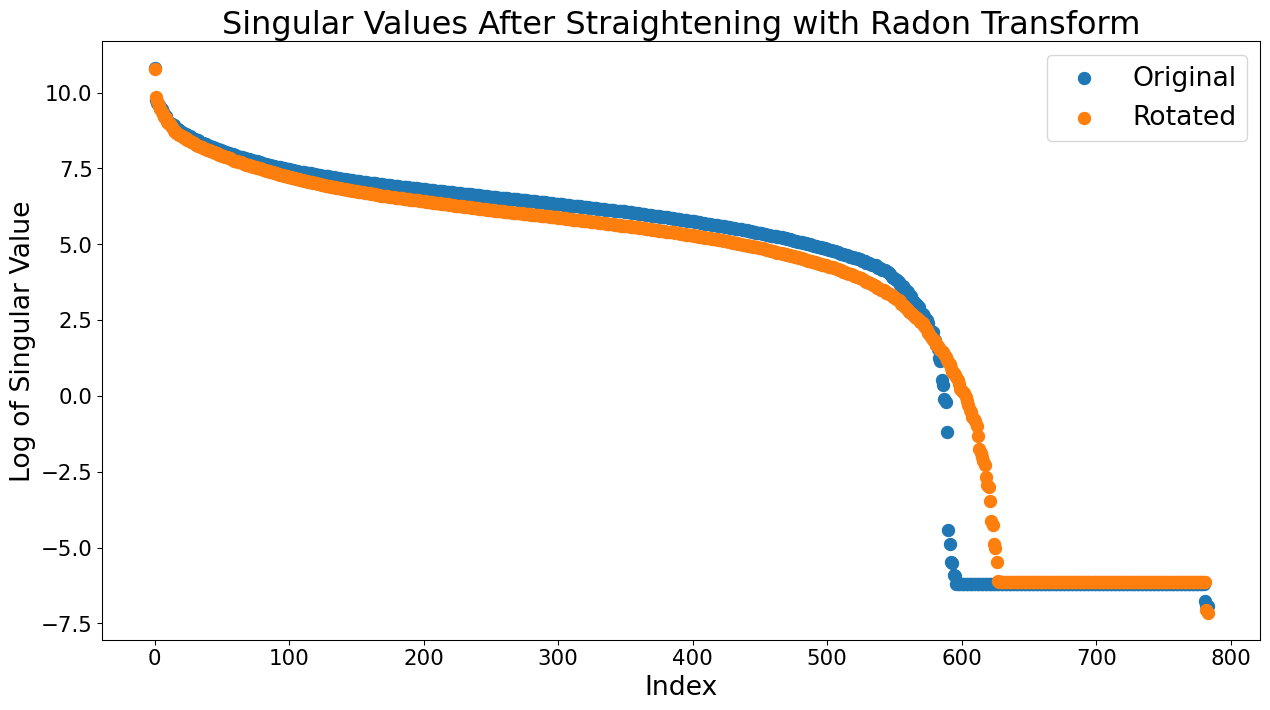

In [ ]:
test_straighten(X[:1000], order=1)

In [ ]:
def plot_straighten(imgs, **kwargs):
    n = kwargs.pop("n", min(10, imgs.shape[0]))
    imgs = imgs.reshape(-1, 28, 28)
    # angles = np.asarray([straightening_angle(img) for img in imgs])
    imgs_rot = np.asarray([
        straighten(img, **kwargs) for img in imgs
    ])
    # imgs_rot_perp = np.asarray([
    #     straighten(img, angle=angle, **kwargs)
    #     for img, angle in zip(imgs, angles + 90)
    # ])

    fig, axes = plt.subplots(n, 3, figsize=(6, 1.5 * n), width_ratios=[5, 1, 5])
    for i in range(n):
        axes[i, 0].imshow(imgs[i], cmap="gray")
        axes[i, 2].imshow(imgs_rot[i], cmap="gray")
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])

        # in axes[i, 1], put text with the angle of rotation along with
        # an arrow pointing right to indicate the transformation between
        # the two images
        axes[i, 1].set_axis_off()
        # axes[i, 1].text(0.5, 0.5, f"{straightening_angle(imgs[i]):.2f}°", ha="center", va="center", fontsize=16)
        axes[i, 1].arrow(0.1, 0.5, 0.75, 0, width=0.05, head_width=0.15, head_length=0.1, fc='k', ec='k')
        axes[i, 1].set_xlim(0, 1)
        axes[i, 1].set_ylim(0, 1)

    plt.tight_layout()

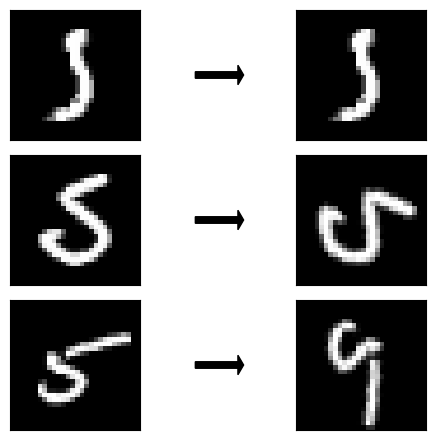

In [ ]:
plot_straighten(digits[5][6:9], order=3)

## Throwing things at the wall

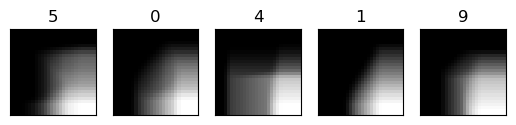

In [43]:
ii = np.cumsum(np.cumsum(X.reshape(-1, 28, 28), axis=-1), axis=-2)
plot_example(ii, y)

In [44]:
def cumsum(img):
    return np.cumsum(np.cumsum(img, axis=-1), axis=-2)

def diff(img):
    return np.diff(np.diff(img, prepend=0, axis=-1), prepend=0, axis=-2)

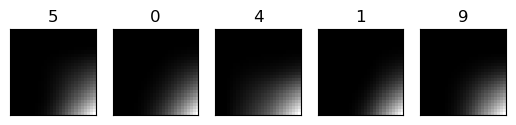

In [47]:
plot_example(((cumsum(cumsum(X.reshape(-1, 28, 28))))), y)

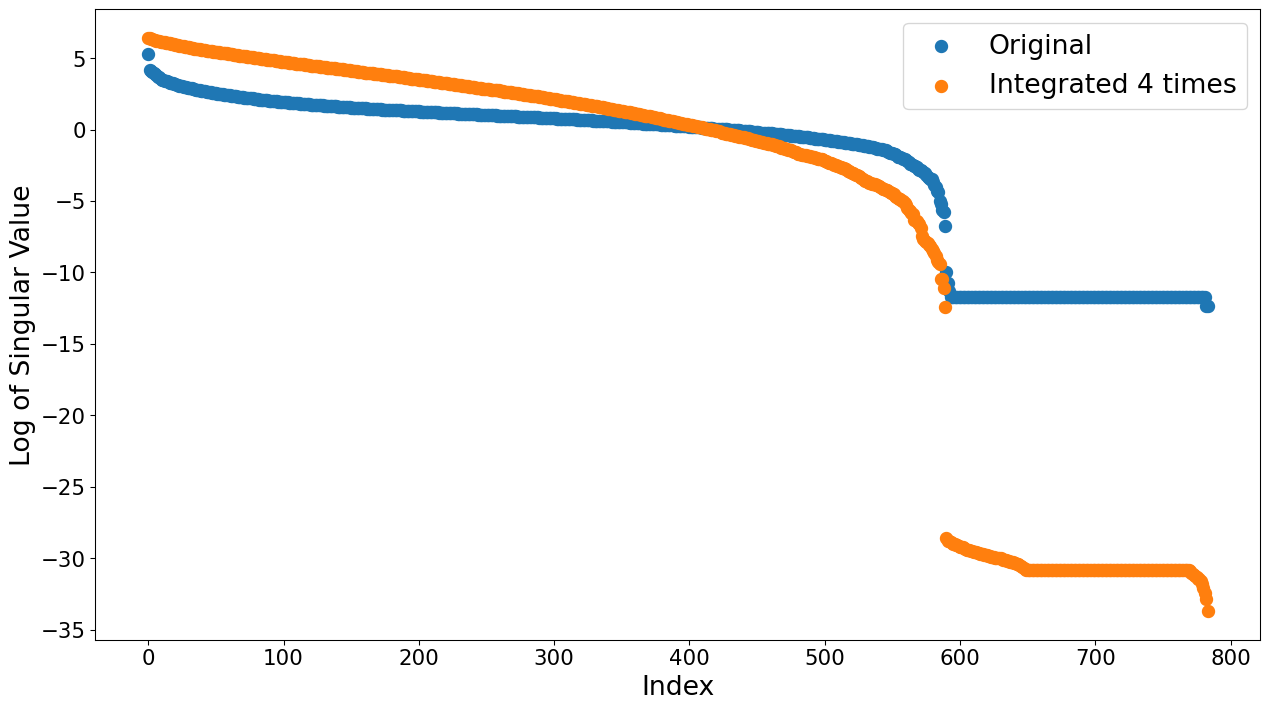

In [ ]:
X_ii = diff(diff(diff(diff(X[:1000].reshape(-1, 28, 28)))))
s_ii = qrsvd(X_ii.reshape(-1, 784))
plot_singular_values(
    s, s_ii,
    labels=["Original", "Integrated 4 times"]
)

## k-means grouping

In [38]:
def twodim(vec, dim):
    result = []
    i = 1
    while i * dim <= len(vec):
        result = result + [vec[(i - 1)*dim:i*dim]]
        i = i + 1
    return result
x = [1, 2, 3, 4]
twodim(x, 2)

[[1, 2], [3, 4]]

In [ ]:
print(ndimage.center_of_mass(np.array(twodim(X[1], 28)))[0])
X = X[:10000]
print(X.shape)
ComX = []
for elem in X:
    ComX = ComX + [[ndimage.center_of_mass(np.array(twodim(elem, 28)))[0], ndimage.center_of_mass(np.array(twodim(elem, 28)))[1]]]
ComX = np.array(ComX)

13.553304422145679
(10000, 784)


In [95]:
# https://dev.to/sajal2692/coding-k-means-clustering-using-python-and-numpy-fg1

def initialize_random_centroids(K, X):
    """Initializes and returns k random centroids"""
    m, n = np.shape(X)
    # a centroid should be of shape (1, n), so the centroids array will be of shape (K, n)
    centroids = np.empty((K, n))
    for i in range(K):
        # pick a random data point from X as the centroid
        centroids[i] =  X[np.random.choice(range(m))] 
    return centroids

def closest_centroid(x, centroids, K):
    """Finds and returns the index of the closest centroid for a given vector x"""
    distances = np.empty(K)
    for i in range(K):
        distances[i] = euclidean_distance(centroids[i], x)
    return np.argmin(distances) # return the index of the lowest distance

def create_clusters(centroids, K, X):
    """Returns an array of cluster indices for all the data samples"""
    m, _ = np.shape(X)
    cluster_idx = np.empty(m)
    for i in range(m):
        cluster_idx[i] = closest_centroid(X[i], centroids, K)
    return cluster_idx

def compute_means(cluster_idx, K, X):
    """Computes and returns the new centroids of the clusters"""
    _, n = np.shape(X)
    centroids = np.empty((K, n))
    for i in range(K):
        points = X[cluster_idx == i] # gather points for the cluster i
        centroids[i] = np.mean(points, axis=0) # use axis=0 to compute means across points
    return centroids

def run_Kmeans(K, X, max_iterations=500):
    """Runs the K-means algorithm and computes the final clusters"""
    # initialize random centroids
    centroids = initialize_random_centroids(K, X)
    # loop till max_iterations or convergance
    print(f"initial centroids: {centroids}")
    for _ in range(max_iterations):
        # create clusters by assigning the samples to the closet centroids
        clusters = create_clusters(centroids, K, X)
        previous_centroids = centroids
        # compute means of the clusters and assign to centroids
        centroids = compute_means(clusters, K, X)
        # if the new_centroids are the same as the old centroids, return clusters
        diff = previous_centroids - centroids
        if not diff.any():
            return clusters
    return clusters

def euclidean_distance(x1, x2):
    """Calculates and returns the euclidean distance between two vectors x1 and x2"""
    return np.sqrt(np.sum(np.power(x1 - x2, 2)))

In [ ]:
testData = [[1, 2], [3, 4], [5, 6]]
#print(ComX)
Xkmeans = run_Kmeans(10, ComX)

initial centroids: [[13.55478933 13.58224633]
 [14.38007961 13.55522298]
 [13.61730225 13.76119377]
 [14.40739227 13.66530338]
 [13.91289479 13.93720789]
 [13.74016655 14.33011955]
 [14.12469549 13.91661706]
 [13.53492214 14.22683125]
 [13.89787702 13.94612898]
 [14.35147307 14.22198509]]


initial centroids: [[ 4.11011863  2.48643712]
 [-3.34841515  8.70507375]
 [-5.72103161 -7.70079191]]


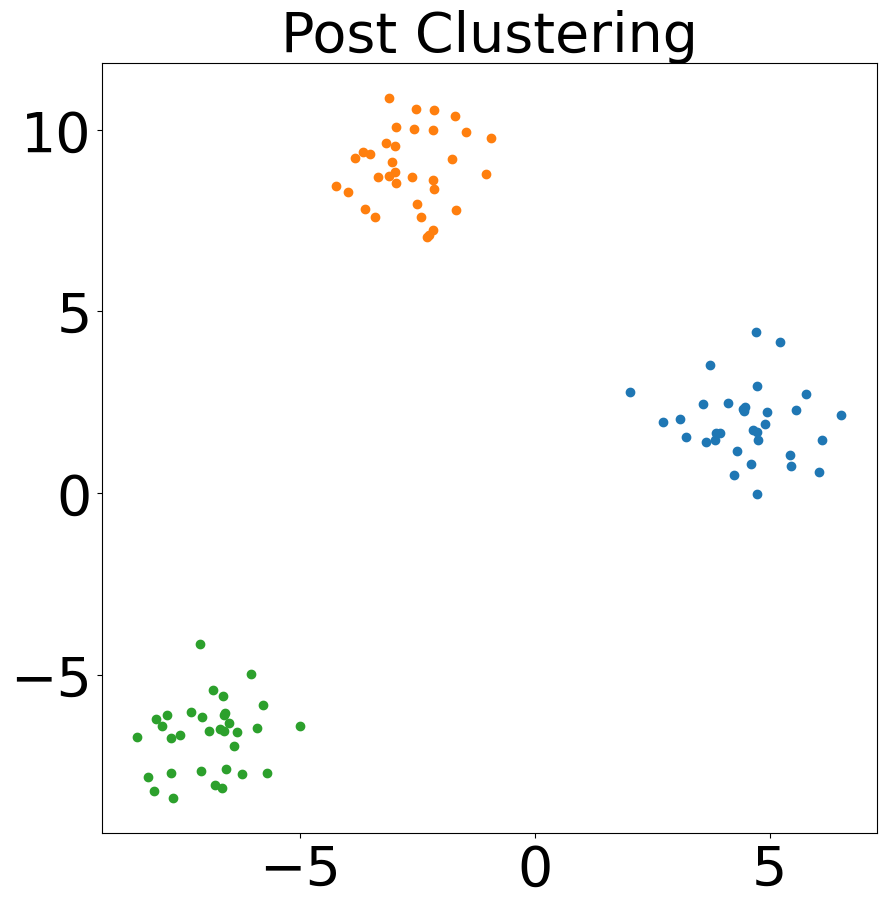

In [ ]:
np.random.seed(42)
from sklearn import datasets
# creating a dataset for clustering
datX, y = datasets.make_blobs()
y_preds = run_Kmeans(3, datX, 10000)

plt.figure(figsize=(10,10))
plt.title('Post Clustering', fontsize = 40)
plt.tick_params(labelsize=40)

for i in range(3):
    xs = []
    ys = []
    for j in range(len(datX)):
        if y_preds[j] == i:
            
            xs = xs + [datX[j][0]]
            ys = ys + [datX[j][1]]
    plt.scatter(xs, ys)

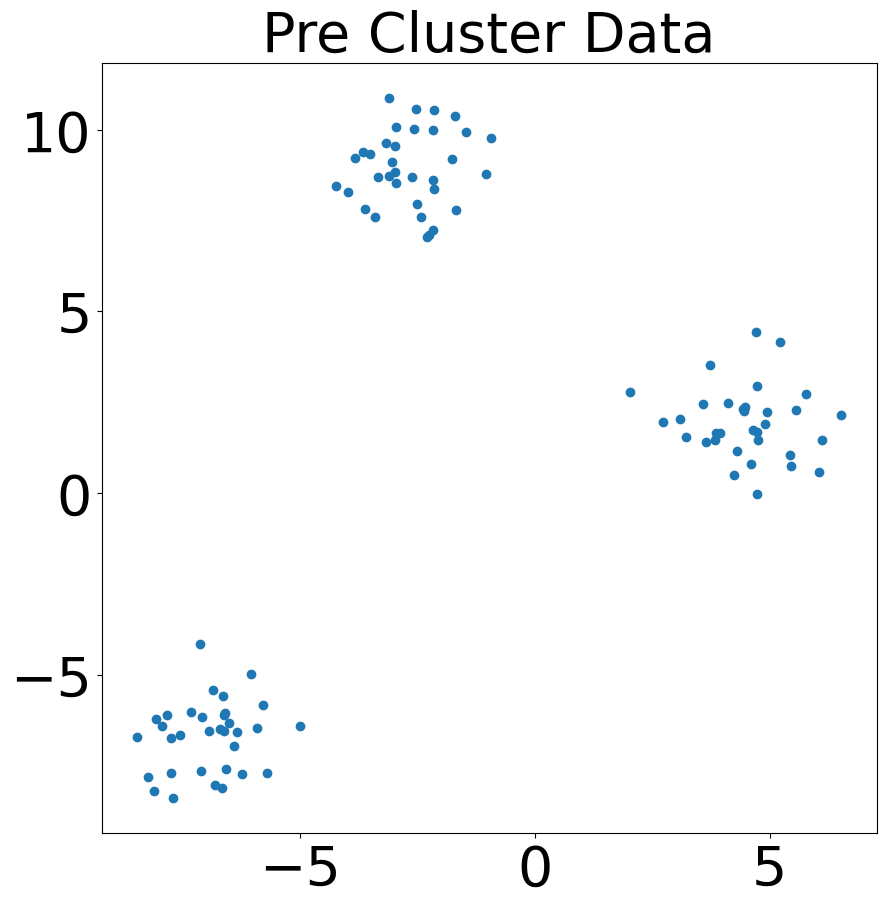

In [ ]:
np.random.seed(42)
plt.figure(figsize=(10,10))
plt.title('Pre Cluster Data', fontsize = 40)
plt.tick_params(labelsize=40)

xs = []
ys = []
for elem in datX:
    xs = xs + [elem[0]]
    ys = ys + [elem[1]]


plt.scatter(xs, ys)

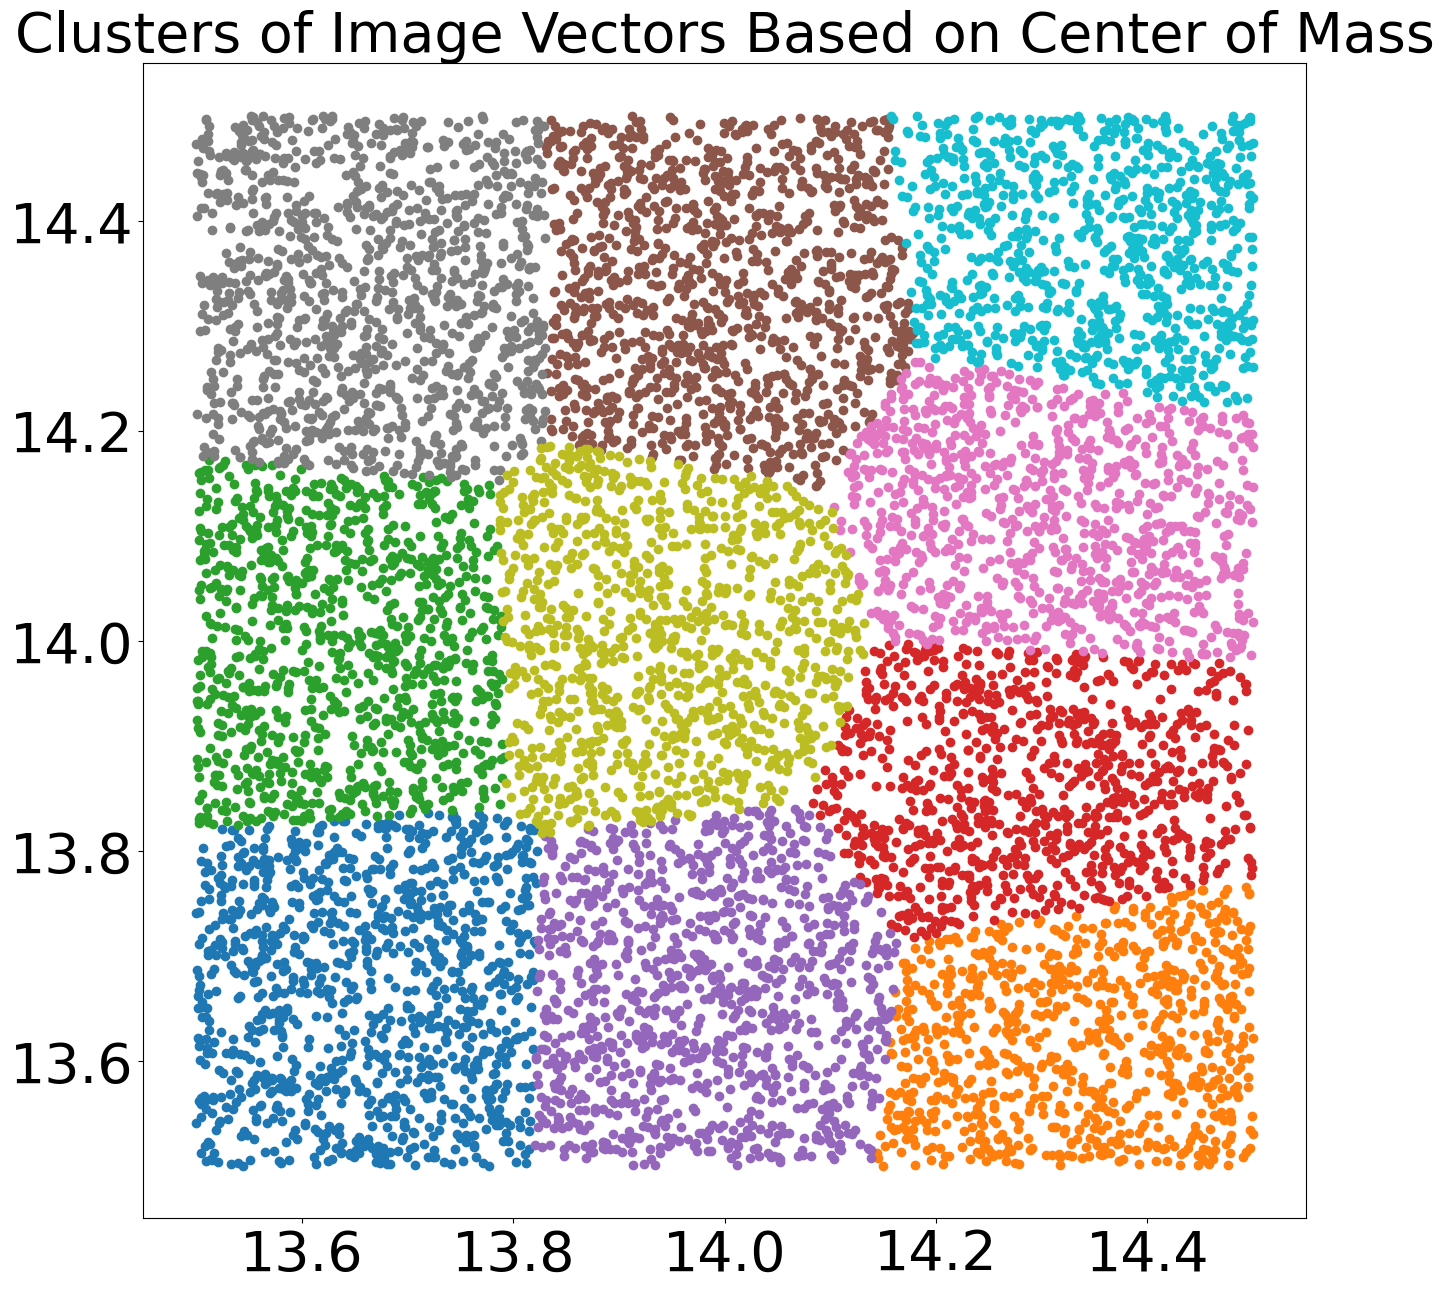

In [ ]:
plt.figure(figsize=(15,15))


for i in range(10):
    xs = []
    ys = []
    for j in range(len(ComX)):
        if Xkmeans[j] == i:
            
            xs = xs + [ComX[j][0]]
            ys = ys + [ComX[j][1]]
    plt.scatter(xs, ys)
    

plt.title('Clusters of Image Vectors Based on Center of Mass', fontsize = 40)
plt.tick_params(labelsize=40)

In [ ]:
def bbox_coords(imgs):
    result = []
    for img in tqdm(imgs):
        img = img.reshape(28,28)
        rmin, rmax, cmin, cmax = find_bbox(img) 
        result = result + [[rmax-rmin, cmax-cmin]]
    return result

Xbbox = bbox_coords(X)

10000it [00:00, 22362.56it/s]


initial centroids: [[20. 16.]
 [20. 20.]
 [20. 16.]
 [20. 14.]
 [20. 17.]
 [20. 12.]
 [17. 20.]
 [20. 15.]
 [20. 12.]
 [20. 20.]]
[1. 1. 1. ... 1. 1. 1.]


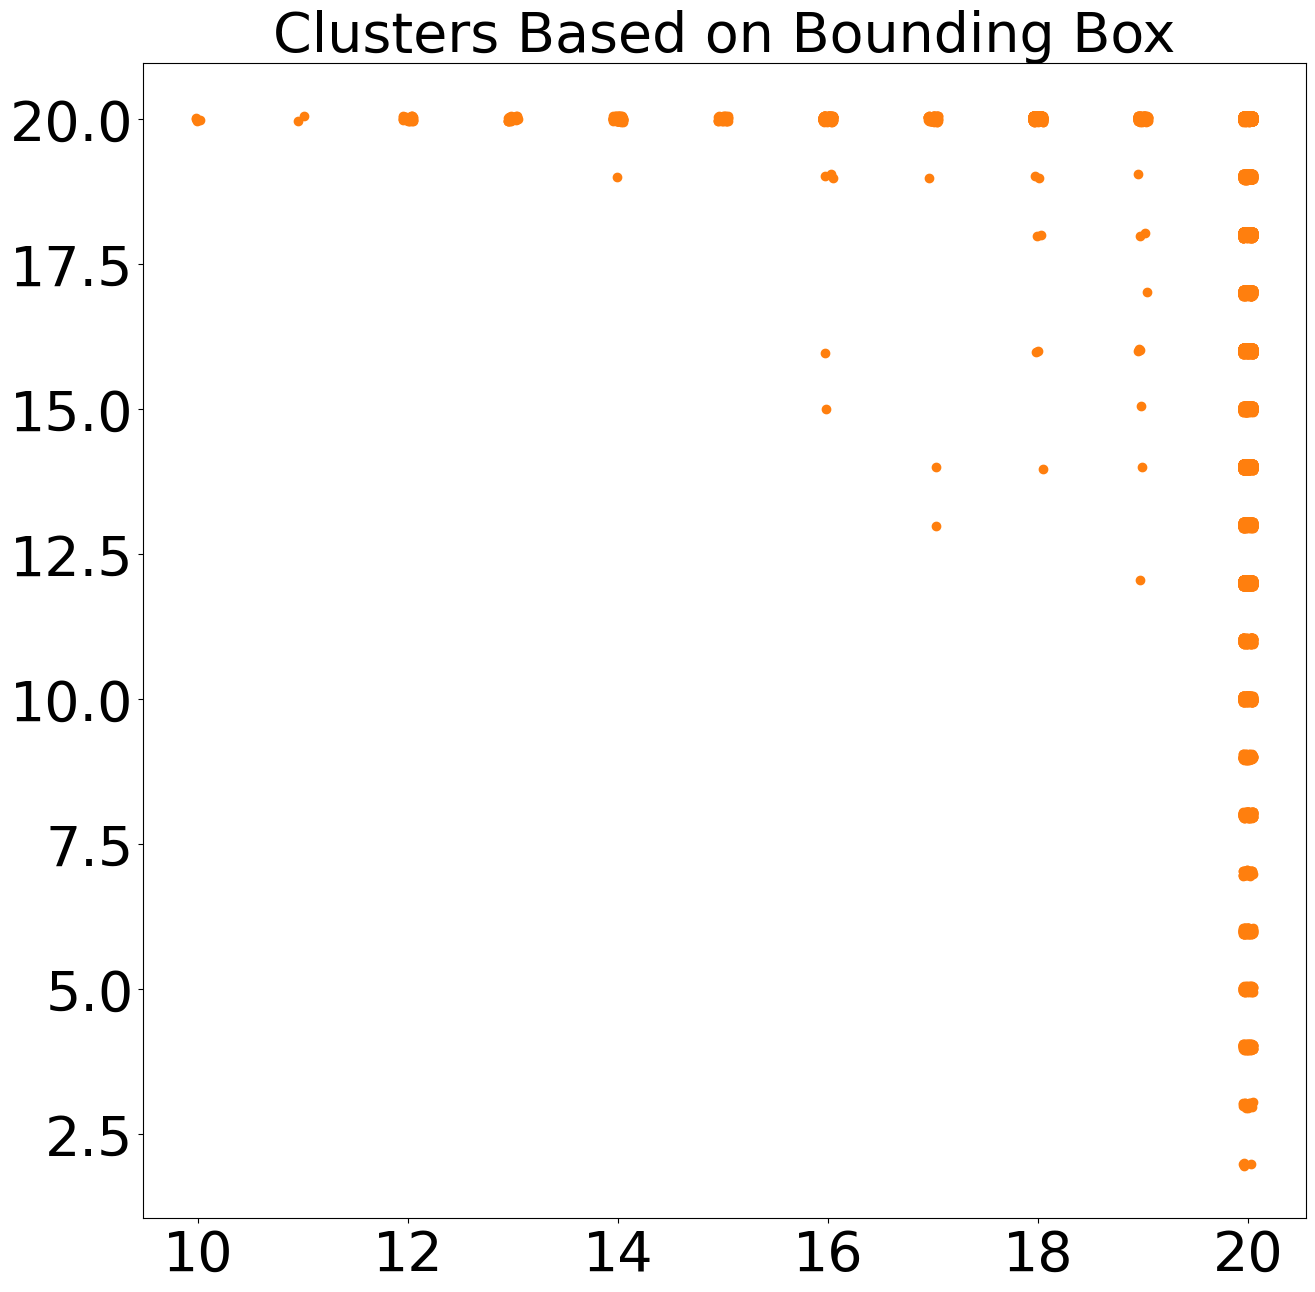

In [ ]:
plt.figure(figsize=(15,15))

Xbbox = np.array(Xbbox)

Xbboxkmeans = run_Kmeans(10, np.array(Xbbox))
print(Xbboxkmeans)

for i in range(10):
    xs = []
    ys = []
    for j in range(len(Xbbox)):
        if Xbboxkmeans[j] == i:
            
            xs = xs + [Xbbox[j][0] + (np.random.rand() - 0.5)*0.1]
            ys = ys + [Xbbox[j][1] + (np.random.rand() - 0.5)*0.1]
    plt.scatter(xs, ys)

plt.title('Clusters Based on Bounding Box', fontsize = 40)
plt.tick_params(labelsize=40)

In [ ]:
X6 = []
for i in range(len(X)):
    X6 = X6 + [np.append(X[i], [Xkmeans[i]])]
X6 = np.array(X6)

In [ ]:
s6 = qrsvd(X6)

In [ ]:
X7 = []
for i in range(len(X)):
    X7 = X7 + [np.append(X[i], [Xbbox[i][0], Xbbox[i][1]])]
X7 = np.array(X7)

In [ ]:
s7 = qrsvd(X7)

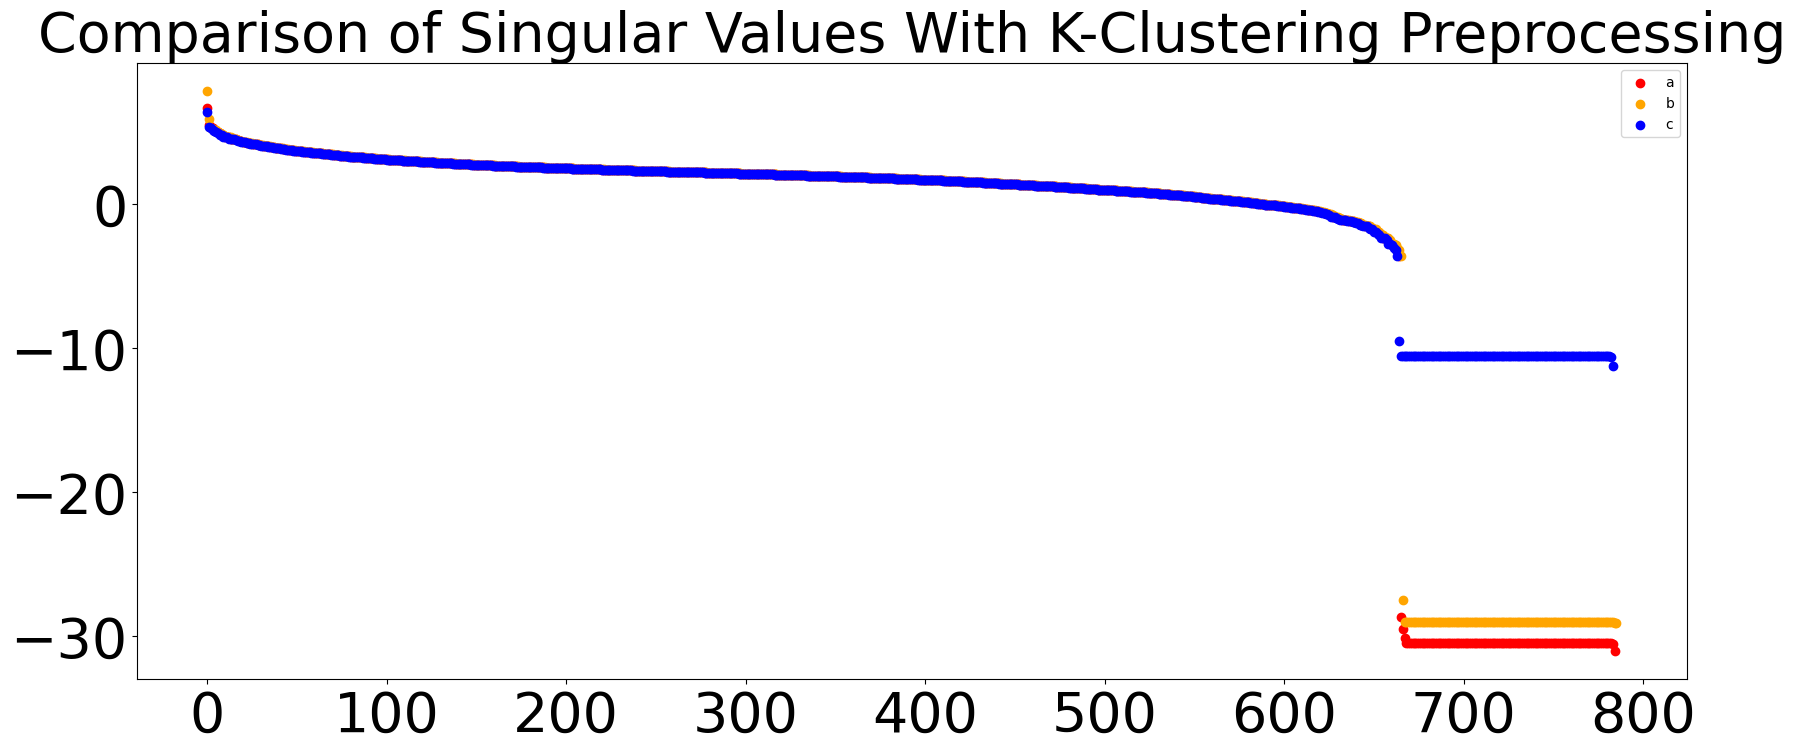

In [ ]:
plt.figure(figsize=(20,8))
a = plt.scatter(np.arange(0,785), np.log(s6), color = 'red')
b = plt.scatter(np.arange(0,786), np.log(s7), color = 'orange')
c = plt.scatter(np.arange(0,784), np.log(s), color = 'blue')
plt.legend(["a", "b", "c"])
plt.title('Comparison of Singular Values With K-Clustering Preprocessing', fontsize = 40)
plt.tick_params(labelsize=40)


In [ ]:
#So i didn't do kcluster with the features of the image as the dimensions, the runtime, even with max settings on idas, would be literally hours if not days. 

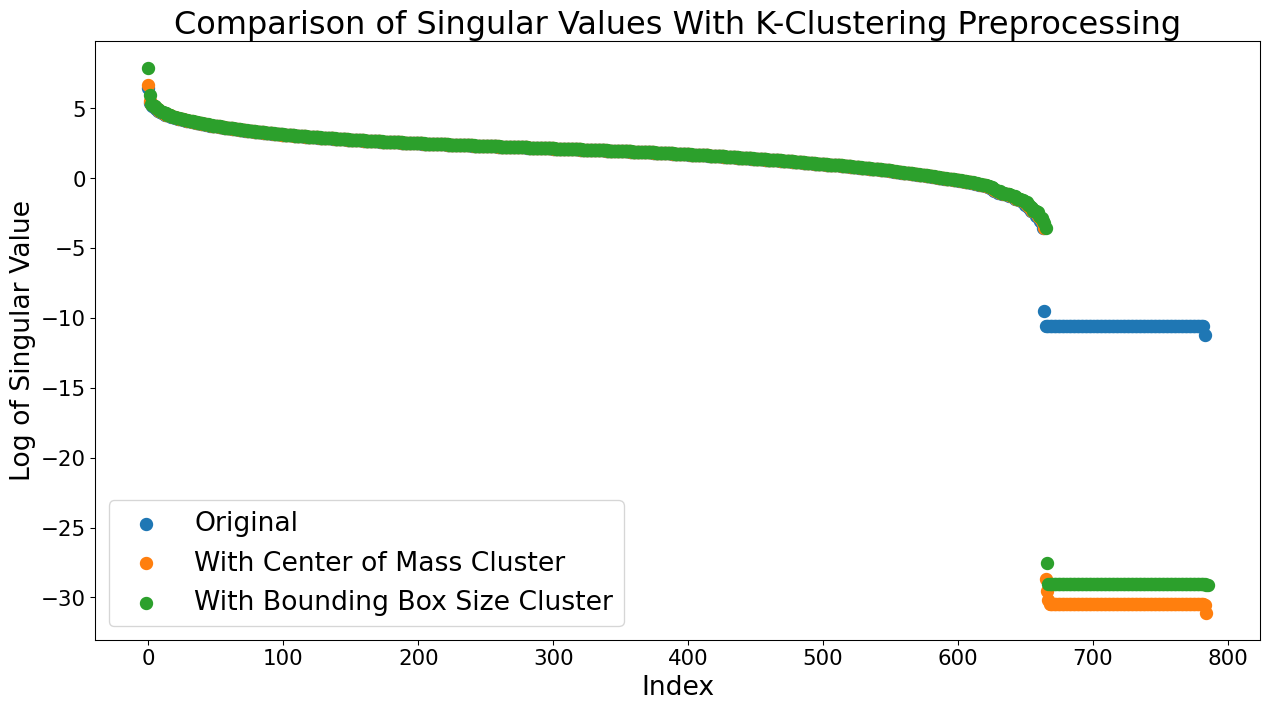

In [ ]:
plot_singular_values(
    s, s6, s7,
    labels=["Original", "With Center of Mass Cluster", "With Bounding Box Size Cluster"],
    title="Comparison of Singular Values With K-Clustering Preprocessing",
    save=True,
)

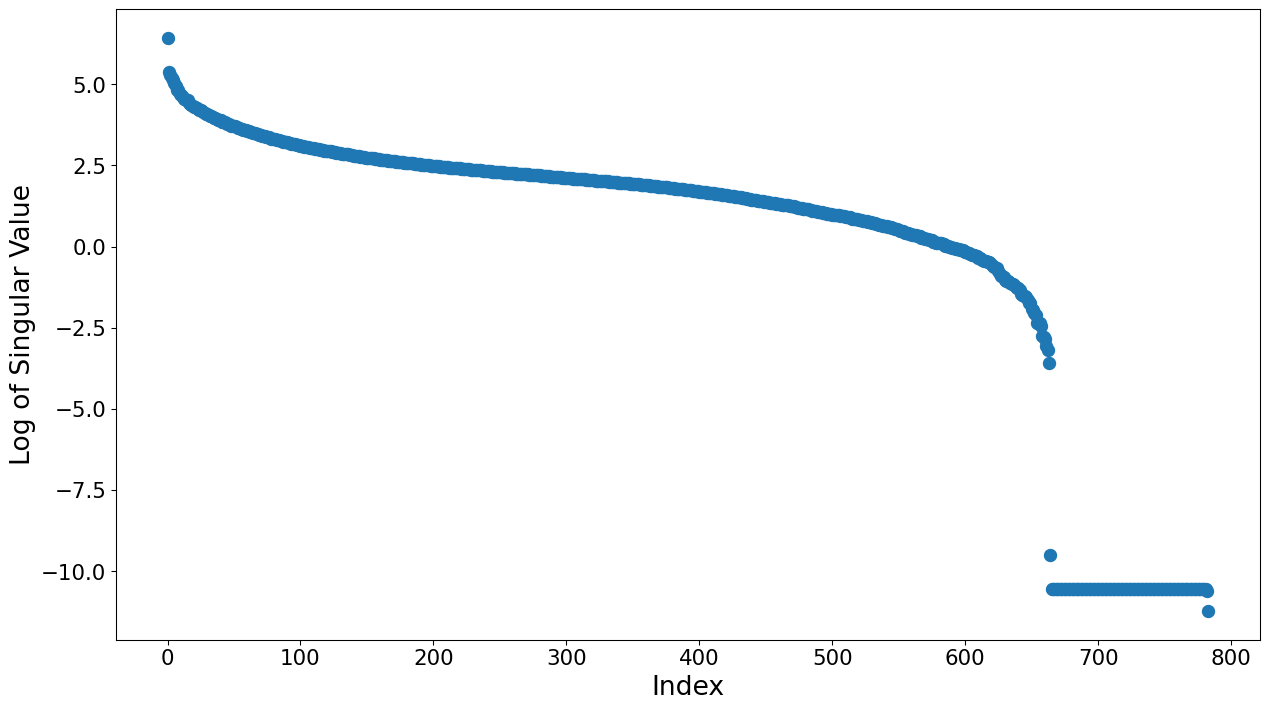

In [ ]:
plot_singular_values(s)